# Sneaker Identifier

1. [Library Imports](#library-imports)
2. [Data Processing](#data-processing)
    1. [Data Processing](#data-reading): Data Reading
    2. [Data Processing](#data-cleaning): Data Cleaning
    3. [Data Processing](#data-upload): Data Upload
3. [Data Analysis](#data-analysis)
    1. [Data Analysis](#dataset-analysis): Dataset Analysis
    2. [Data Analysis](#dataset-analysis): Image Analysis

## Library Imports

In [51]:
## General Imports
import requests
import json
import pandas as pd
import time
import numpy as np
import os

## Module Imports
import src.sample as main
import src.extract_images as ei

## Image Manipulation
import urllib
from PIL import Image
import matplotlib.pyplot as plt

## MongoDB
from pymongo import MongoClient
import pickle
import bson
import io


## Data Retrieval Imports
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [ ]:
def make_request(url, headers):
    try: 
        url = 'https://graphql.stadiumgoods.com/graphql'
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Safari/605.1.15',
                   'Content-Type': 'application/json'
                }
        body = '{"operationId":"sg-front/cached-a41eba558ae6325f072164477a24d3c2","variables":{"categorySlug":"","initialSearchQuery":"'+shoe.styleID+'","initialSort":"RELEVANCE","includeUnavailableProducts":null,"filteringOnCategory":false,"filteringOnBrand":false,"filteringOnMensSizes":false,"filteringOnKidsSizes":false,"filteringOnWomensSizes":false,"filteringOnApparelSizes":false,"filteringOnGender":false,"filteringOnColor":false,"filteringOnPriceRange":false},"locale":"USA_USD"}',
        http2 = True,
        responseType = 'json'

        requests.post(url, headers=headers)
    except Exception as e:
        print(e.message, e.args)


## Data Processing

### Data Reading

In [13]:
folder = os.path.abspath(os.curdir)
file = os.path.join(folder, "sneaker_json.json")

In [14]:
with open(file, "rb") as read:
    sneaker_json = json.load(read)

In [15]:
sneaker_df = pd.read_json(file)
sneaker_df.head()

,lowestResellPrice,imageLinks,_id,shoeName,brand,silhoutte,styleID,make,colorway,retailPrice,thumbnail,releaseDate,description,category,urlKey,resellLinks,goatProductId
0,"{'stockX': 269, 'flightClub': 311, 'goat': 264}",[],633e29973c601366c28498eb,Jordan 4 Retro SE Black Canvas,Jordan,Jordan 4 Retro SE,DH7138-006,Jordan 4 Retro SE,Black/Light Steel Grey/White/Fire Red,210.0,https://images.stockx.com/images/Air-Jordan-4-...,2022-10-05,The Air Jordan 4 Retro 'Black Canvas' blends a...,sneakers,air-jordan-4-retro-se-black-canvas,{'stockX': 'https://stockx.com/air-jordan-4-re...,933532.0
1,"{'stockX': 99, 'flightClub': 106, 'goat': 106}",[],633e29973c601366c28498ec,NikeCraft General Purpose Shoe Tom Sachs Archi...,Nike,NikeCraft General Purpose Shoe,DA6672-700,NikeCraft General Purpose Shoe,Dark Sulfur/White-Light Cream,110.0,https://images.stockx.com/images/NikeCraft-Gen...,2022-09-02,Tom Sachs works with Nike again on a new model...,sneakers,nikecraft-general-purpose-shoe-tom-sachs-yellow,{'stockX': 'https://stockx.com/nikecraft-gener...,981386.0
2,"{'stockX': 190, 'flightClub': 204, 'goat': 187}",[],633e29973c601366c28498ed,Jordan 3 Retro Fire Red (2022),Jordan,Jordan 3 Retro,DN3707-160,Jordan 3 Retro,White/Fire Red/Cement Grey/Black,210.0,https://images.stockx.com/images/Air-Jordan-3-...,2022-09-10,The Air Jordan 3 Retro 'Fire Red' sees one of ...,sneakers,air-jordan-3-retro-fire-red-2022,{'stockX': 'https://stockx.com/air-jordan-3-re...,942086.0
3,"{'stockX': 140, 'flightClub': 154, 'goat': 154}",[],633e29973c601366c28498ee,Jordan 1 Retro Low OG Black Dark Powder Blue,Jordan,Jordan 1 Retro Low OG,CZ0790-104,Jordan 1 Retro Low OG,White/Dark Powder Blue/Black,130.0,https://images.stockx.com/images/Air-Jordan-1-...,2022-07-29,"Paying homage to Michael Jordan's alma mater, ...",sneakers,air-jordan-1-retro-low-og-unc,{'stockX': 'https://stockx.com/air-jordan-1-re...,941118.0
4,"{'stockX': 101, 'flightClub': 101, 'goat': 97}",[],633e29973c601366c28498ef,Crocs Pollex Clog by Salehe Bembury Tide,Crocs,Crocs Pollex Clog,207393-4ST,Crocs Pollex Clog,Turquoise Tonic,85.0,https://images.stockx.com/images/Crocs-Pollex-...,2022-09-22,,sneakers,crocs-pollex-clog-by-salehe-bembury-tide,{'stockX': 'https://stockx.com/crocs-pollex-cl...,952231.0


### Data Cleaning

In [16]:
## Let's find any sneakers re-sale items that are not specifically sneakers, and filter them out

sneaker_df = sneaker_df[sneaker_df['category'] == 'sneakers'] 

In [17]:
## Let's see what columns we can use as unique identifier

def count_unique(df):

    unique_dict = {}

    for col in df.columns:
        vals = df[col].value_counts()
        is_unique = all(vals == 1)
        if (is_unique == True): 
            #print(is_unique)
            unique_dict[col] = is_unique
            #print(f"{col}: Is a valid unique_identifier") 
        else: 
            unique_dict[col] = is_unique
            #print(f"{col}: Not a valid unique_identifier")

    return  pd.DataFrame.from_dict(unique_dict, orient = 'index', columns = ["is_unique"])


In [18]:
unique_cols = count_unique(sneaker_df)
print(unique_cols)

                   is_unique
lowestResellPrice      False
imageLinks             False
_id                     True
shoeName                True
brand                  False
silhoutte              False
styleID                False
make                   False
colorway               False
retailPrice            False
thumbnail               True
releaseDate            False
description            False
category               False
urlKey                  True
resellLinks             True
goatProductId           True


In [19]:
unique_cols[unique_cols["is_unique"] == True].index.values

array(['_id', 'shoeName', 'thumbnail', 'urlKey', 'resellLinks',
       'goatProductId'], dtype=object)

In [20]:
sneaker_df.head()

,lowestResellPrice,imageLinks,_id,shoeName,brand,silhoutte,styleID,make,colorway,retailPrice,thumbnail,releaseDate,description,category,urlKey,resellLinks,goatProductId
0,"{'stockX': 269, 'flightClub': 311, 'goat': 264}",[],633e29973c601366c28498eb,Jordan 4 Retro SE Black Canvas,Jordan,Jordan 4 Retro SE,DH7138-006,Jordan 4 Retro SE,Black/Light Steel Grey/White/Fire Red,210.0,https://images.stockx.com/images/Air-Jordan-4-...,2022-10-05,The Air Jordan 4 Retro 'Black Canvas' blends a...,sneakers,air-jordan-4-retro-se-black-canvas,{'stockX': 'https://stockx.com/air-jordan-4-re...,933532.0
1,"{'stockX': 99, 'flightClub': 106, 'goat': 106}",[],633e29973c601366c28498ec,NikeCraft General Purpose Shoe Tom Sachs Archi...,Nike,NikeCraft General Purpose Shoe,DA6672-700,NikeCraft General Purpose Shoe,Dark Sulfur/White-Light Cream,110.0,https://images.stockx.com/images/NikeCraft-Gen...,2022-09-02,Tom Sachs works with Nike again on a new model...,sneakers,nikecraft-general-purpose-shoe-tom-sachs-yellow,{'stockX': 'https://stockx.com/nikecraft-gener...,981386.0
2,"{'stockX': 190, 'flightClub': 204, 'goat': 187}",[],633e29973c601366c28498ed,Jordan 3 Retro Fire Red (2022),Jordan,Jordan 3 Retro,DN3707-160,Jordan 3 Retro,White/Fire Red/Cement Grey/Black,210.0,https://images.stockx.com/images/Air-Jordan-3-...,2022-09-10,The Air Jordan 3 Retro 'Fire Red' sees one of ...,sneakers,air-jordan-3-retro-fire-red-2022,{'stockX': 'https://stockx.com/air-jordan-3-re...,942086.0
3,"{'stockX': 140, 'flightClub': 154, 'goat': 154}",[],633e29973c601366c28498ee,Jordan 1 Retro Low OG Black Dark Powder Blue,Jordan,Jordan 1 Retro Low OG,CZ0790-104,Jordan 1 Retro Low OG,White/Dark Powder Blue/Black,130.0,https://images.stockx.com/images/Air-Jordan-1-...,2022-07-29,"Paying homage to Michael Jordan's alma mater, ...",sneakers,air-jordan-1-retro-low-og-unc,{'stockX': 'https://stockx.com/air-jordan-1-re...,941118.0
4,"{'stockX': 101, 'flightClub': 101, 'goat': 97}",[],633e29973c601366c28498ef,Crocs Pollex Clog by Salehe Bembury Tide,Crocs,Crocs Pollex Clog,207393-4ST,Crocs Pollex Clog,Turquoise Tonic,85.0,https://images.stockx.com/images/Crocs-Pollex-...,2022-09-22,,sneakers,crocs-pollex-clog-by-salehe-bembury-tide,{'stockX': 'https://stockx.com/crocs-pollex-cl...,952231.0


In [21]:
sneaker_df['shoeName'].value_counts()

Jordan 4 Retro SE Black Canvas                                  1
NikeCraft General Purpose Shoe Tom Sachs Archive Dark Sulfur    1
adidas Yeezy Slide Soot                                         1
Nike Blazer Low Off-White Black Electro Green                   1
Jordan 1 Retro High Light Smoke Grey                            1
                                                               ..
Jordan 1 Retro High OG Bleached Coral (GS)                      1
Jordan 7 Retro Citrus (2022)                                    1
Nike Air Max Penny 1 Orlando (2022)                             1
Nike Dunk Low Disrupt 2 Panda (W)                               1
Jordan 13 Retro Flint (2020)                                    1
Name: shoeName, Length: 832, dtype: int64

In [22]:
## We know that none of our shoeName's are NA
print(any(sneaker_df.notna()['shoeName'] == False))
assert(len(sneaker_df) == len(sneaker_df['shoeName']))

## Let's set our dataframe index _id which is a unique _id
sneaker_df = sneaker_df.set_index('shoeName')

False


In [24]:
## We have several columns that could server as unique identifiers, although we want to find out if there's any combination of columns that
## might produce better results

unique_df = sneaker_df.filter(items = unique_cols[unique_cols["is_unique"] == True].index.values, axis = 1)
unique_df


## We're going to take the shoe_name, silhoutte, styleId, and colorway to be our unique_query parameters
unique_id = pd.DataFrame(sneaker_df[['silhoutte', 'colorway']].agg('-'.join, axis = 1), columns=['query'])

## Let's add the query column to our sneaker's dataframe
sneaker_df['query'] = (unique_id.index + '-' + unique_id['query']).to_list()

### Data Upload

#### Connecting to Database

In [52]:
client = main.get_database()
for db in client.list_databases():
    print(db)

{'name': 'admin', 'sizeOnDisk': 40960, 'empty': False}
{'name': 'config', 'sizeOnDisk': 110592, 'empty': False}
{'name': 'local', 'sizeOnDisk': 90112, 'empty': False}
{'name': 'sneakers', 'sizeOnDisk': 1634304, 'empty': False}


1) Download the version-specific web browser driver (for Chrome: https://chromedriver.chromium.org/downloads)
2) Un-zip the file
3) Create a Service-type variable (parameters: driver path)
4) Create a Chrome webdriver with your service
5) Run the cell, and your browser will open

**-------------Important-------------**
- "chromedriver" cannot be verified: 
    - Type into your terminal: xattr -d com.apple.quarantine <path-of-chromedriver-executable>

In [55]:
## Specify the driver path
driver_path = '/Users/nicolastobon/Library/Mobile Documents/com~apple~CloudDocs/Data Projects/Sneakers-Classifier/chromedriver'
driver = ei.select_driver(driver_path)

Google Search Tips: 

**Enclose your keywords within quotes and Google will do an exact phrase search.**
- Use case
    - Find classes or training on direct sales. It can be any type of training or class, but it must contain “direct sales”.
- Syntax
    - "[keyword 1] [keyword 2]" [keyword 3]
- Example
    - "direct sales" training

#### Extracting Images

In [50]:
## Use a test query
query = 'DN3707-160-Jordan 3 Retro Fire Red (2022)-Jordan 3 Retro-White/Fire Red/Cement Grey/Black'
image_links = ei.extract(query, 10, driver, 1)

NameError: name 'ei' is not defined

In [97]:

collection = client['sneakers']['test']

def load_images(sneaker):
    ## The collection currently has one image, and that image is stored as a dictionary. We will access the image_data by searching the query
    for sneaker in collection.find():
        for image in sneaker[query]:
            np.array(Image.open(io.BytesIO(image)))

## The collection currently has one image, and that image is stored as a dictionary. We will access the image_data by searching the query


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


### Data Analysis

### Dataset Analysis

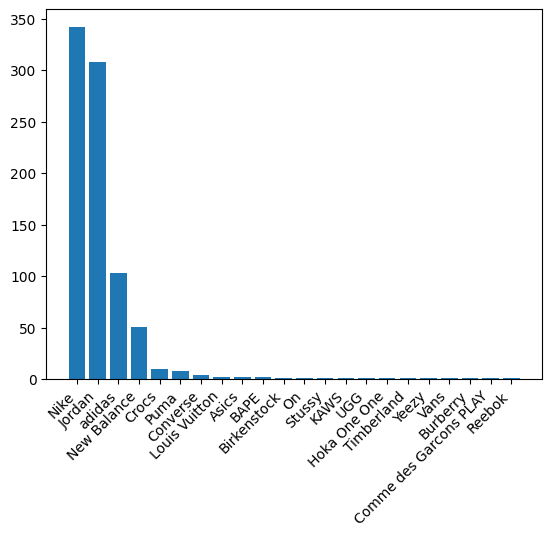

In [96]:
## Let's visualize a look at the most relevant sneaker brands

print(sneaker_df['brand'].value_counts())

brands = sneaker_df['brand']

fig = plt.figure()
ax = fig.add_subplot()
brands_bar = ax.bar(brands.value_counts().index, brands.value_counts().values)
plt.xticks(rotation = 45, ha="right")
plt.show()

### Image Analysis

In [6]:
test_dir = os.path.join(folder, "test")
test_dir

'/Users/nicolastobon/Library/Mobile Documents/com~apple~CloudDocs/Data Projects/StockX API Testing/test'

In [40]:
for file in os.listdir(test_dir):
    image = Image.open(os.path.join(test_dir, file)) 
    print(image.format)
    print(image.mode)
    print(image.size)
    print('\n')
    image = image.resize((256,256))
    image.show()

JPEG
RGB
(1000, 1250)


JPEG
RGB
(1860, 1860)


JPEG
RGB
(1860, 1860)


JPEG
RGB
(640, 434)


WEBP
RGB
(1400, 1000)


JPEG
RGB
(480, 600)


JPEG
RGB
(1280, 720)


JPEG
RGB
(960, 1200)


JPEG
RGB
(1200, 750)


JPEG
RGB
(1070, 760)


